# Setup

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [2]:
%matplotlib notebook

# Load Steven's data

In [5]:
from pyspark.sql import SparkSession
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)
import axs
catalog = axs.AxsCatalog(spark)
joined_df = catalog.load("6_4_20_stevengs_top_hat_and_skew_normal_fits_r_band")

In [ ]:
df = joined_df.toPandas()

In [33]:
# Sort by significance
sig = [i['significance'] for i in df['dip']]
sig_df = df.iloc[np.argsort(sig)[::-1]]

In [127]:
def skew_normal(x, skew, loc, xscale, yscale, offset):
    from scipy.stats import skewnorm
    _dist = skewnorm(skew, loc=loc, scale=xscale)
    return yscale * _dist.pdf(x) + offset

def top_hat(x, loc, width, depth, offset):
    import numpy as np
    x = np.array(x)
    left = loc - width / 2
    right = loc + width / 2
    outside = (x < left) | (x > right)
    inside = np.logical_not(outside)
    
    y = np.zeros(x.shape)
    y[outside] = offset
    y[inside] = offset + depth
    
    return y

In [143]:
def plot_row(row):
    dip = row['dip']

    plt.figure(figsize=(8, 6))
    window_r = row['window_r']
    #plt.errorbar(window_r['x'], window_r['y'], window_r['yerr'], fmt='.')
    plt.errorbar(row['mjd_r'], row['mag_r'], row['magerr_r'], fmt='o', c='C3')
    
    
    start_mjd = dip['window_start_mjd']
    end_mjd = dip['window_end_mjd']
    pad = end_mjd - start_mjd
    
    plt.axvline(start_mjd, c='k', ls='--')
    plt.axvline(end_mjd, c='k', ls='--')
    
    plt.xlim(start_mjd - pad, end_mjd + pad)
    x = np.linspace(start_mjd - pad, end_mjd + pad, 1000)
    
    popt = row['fit_r_skew_normal']['popt']
    model = skew_normal(x, *popt)
    plt.plot(x, model, label=f'Skew normal fit - {row["model_error_around_dip_r_skew_normal"][1]:.2f}')
    
    popt = row['fit_r_top_hat']['popt']
    model = top_hat(x, *popt)
    plt.plot(x, model, label=f'Top hat fit - {row["model_error_around_dip_r_top_hat"][1]:.2f}')
    
    plt.gca().invert_yaxis()
    plt.legend()

In [197]:
chisq_skew = np.array([i[1] for i in sig_df['model_error_around_dip_r_skew_normal']])
chisq_tophat = np.array([i[1] for i in sig_df['model_error_around_dip_r_top_hat']])
skew = np.array([i['popt'][0] for i in sig_df['fit_r_skew_normal']])
xscale = np.array([i['popt'][2] for i in sig_df['fit_r_skew_normal']])
yscale = np.array([i['popt'][3] for i in sig_df['fit_r_skew_normal']])

# Cuts for asymmetric dips

In [193]:
cut = (
    (chisq_skew < 5)
    & (np.abs(skew) > 2)
    & (np.abs(xscale) < 50)
    & (chisq_tophat - chisq_skew > 2)
    #& (np.abs(yscale) > 10.)
)

In [198]:
%matplotlib inline

In [199]:
np.sum(cut)

817

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

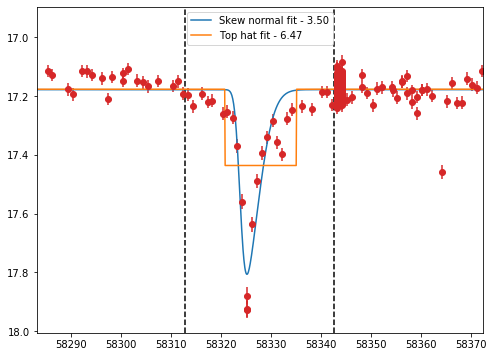

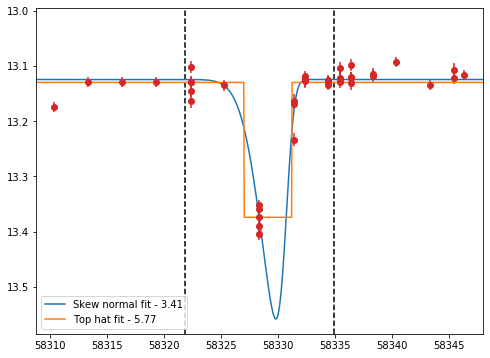

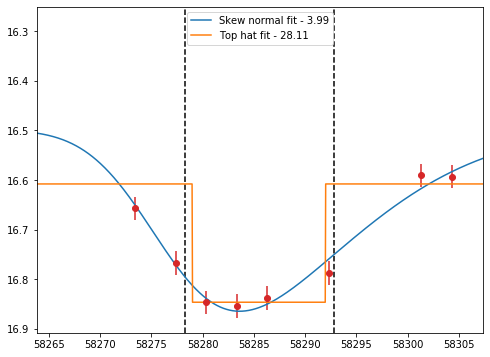

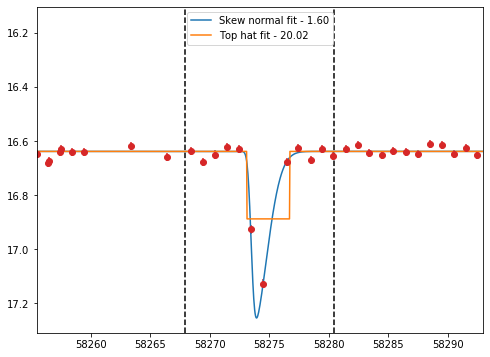

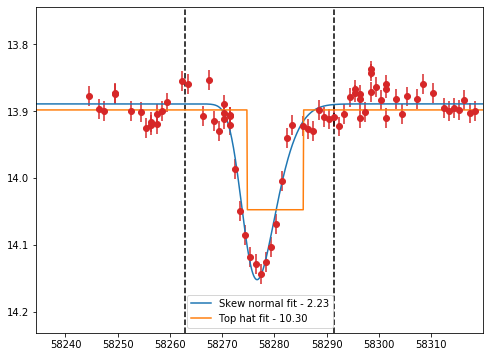

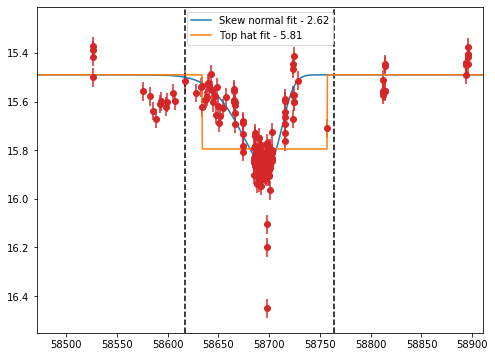

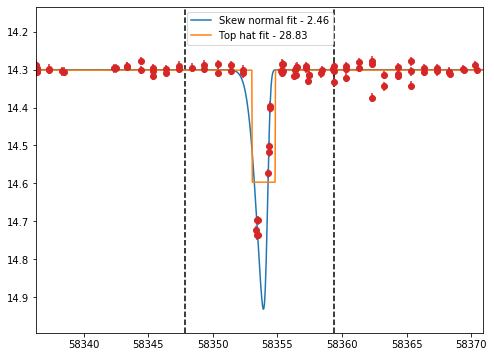

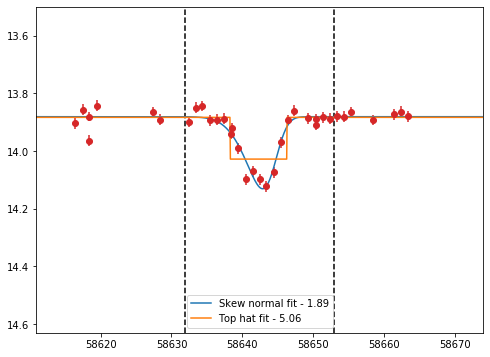

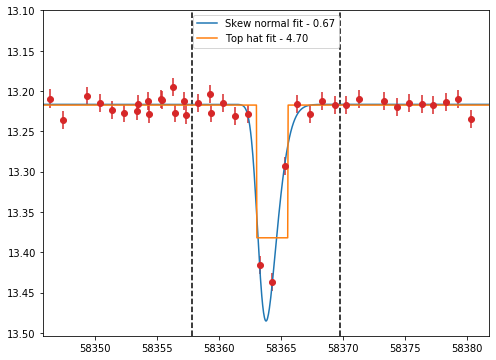

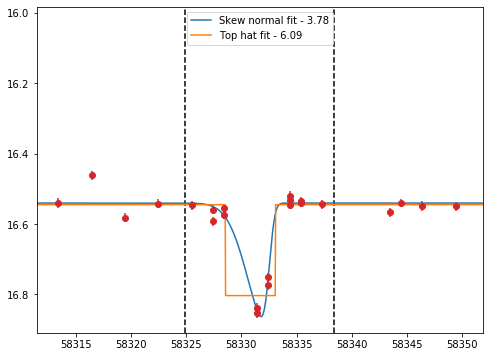

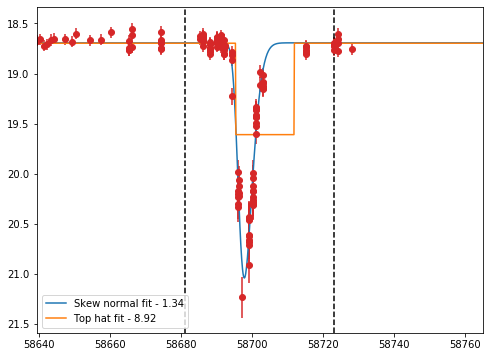

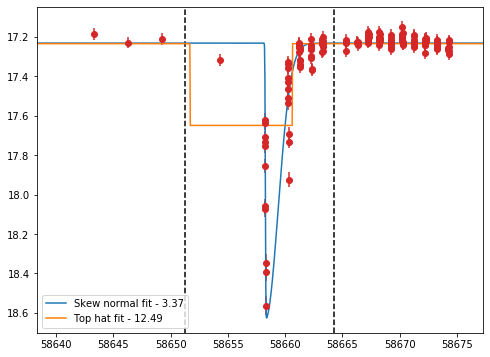

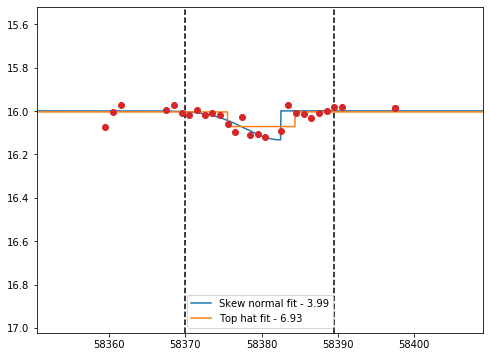

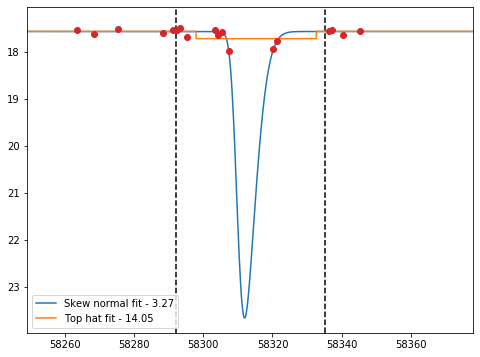

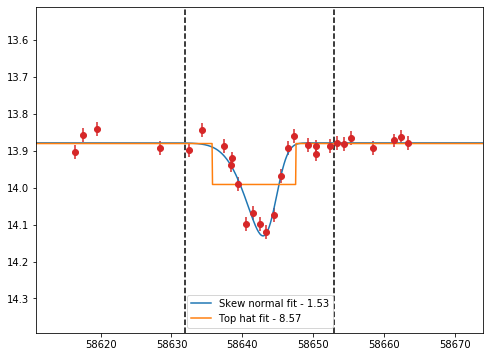

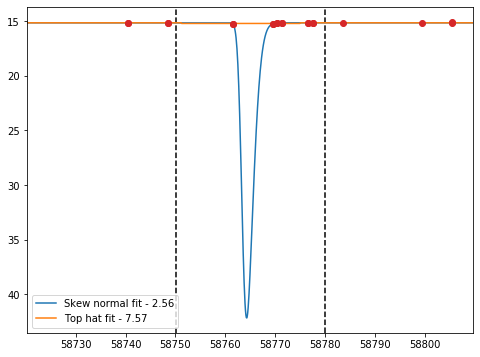

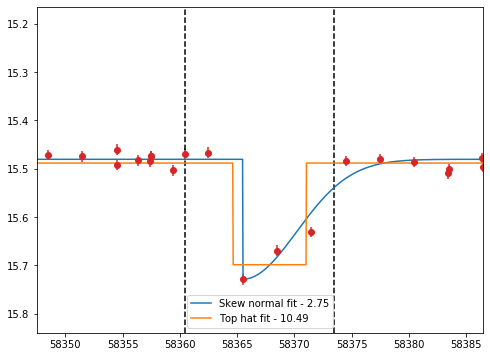

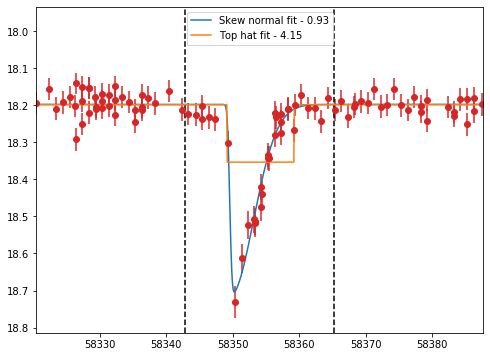

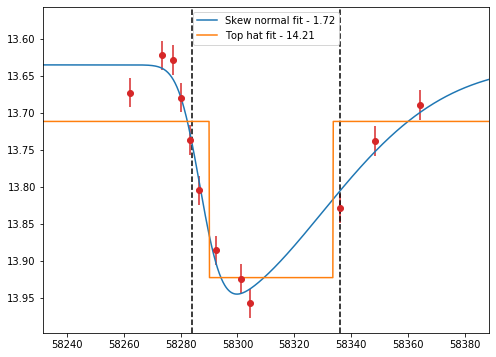

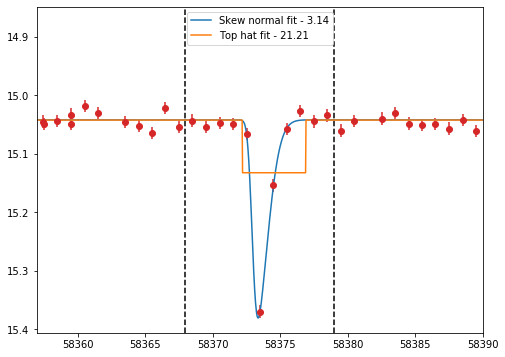

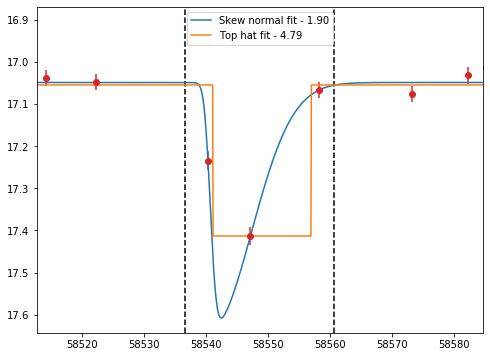

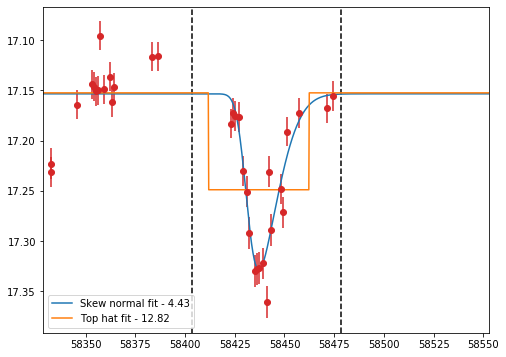

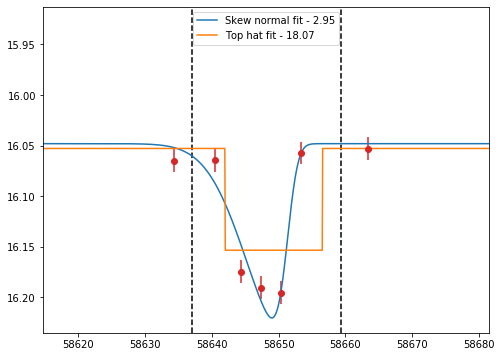

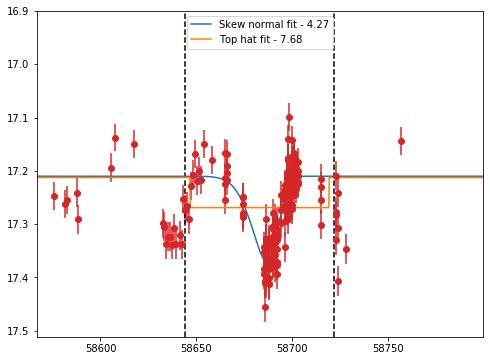

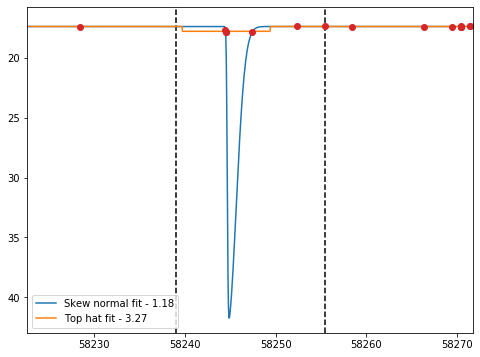

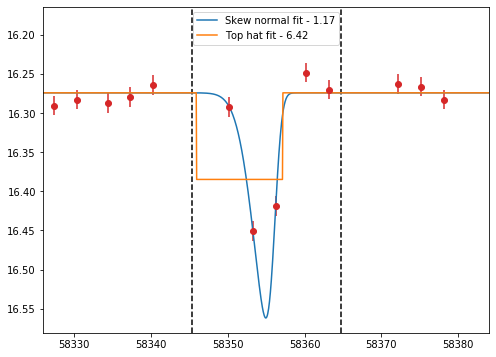

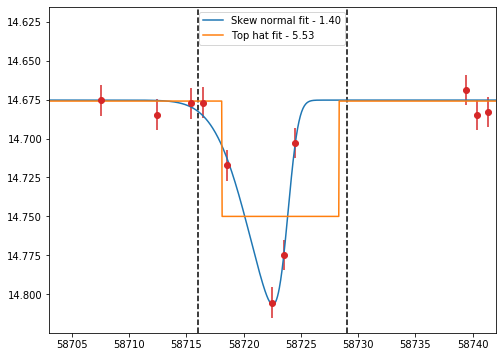

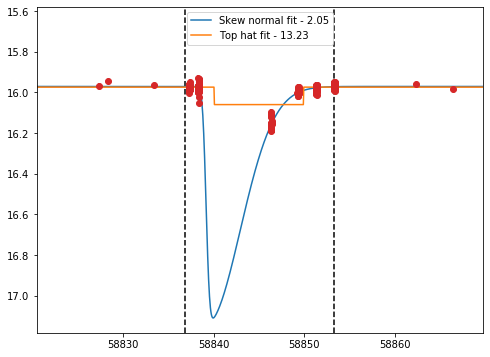

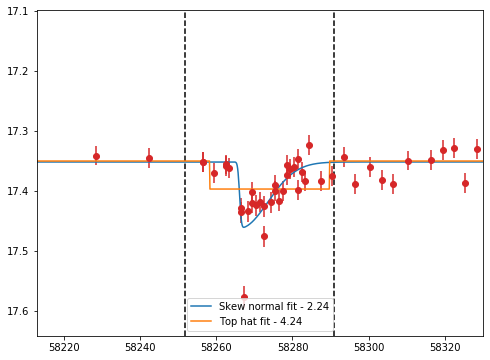

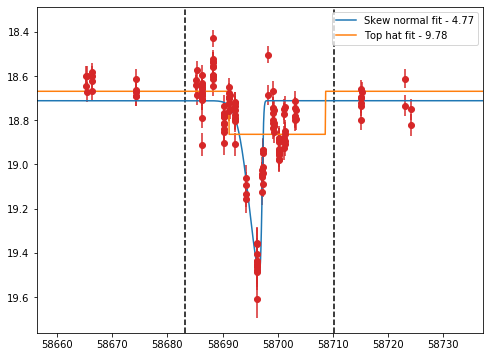

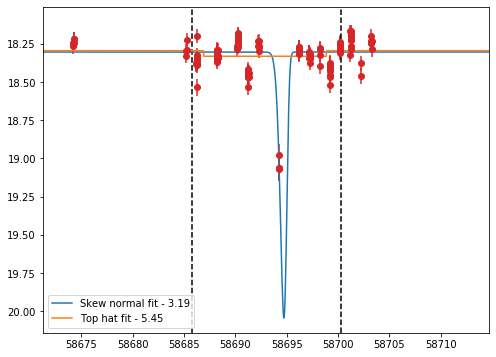

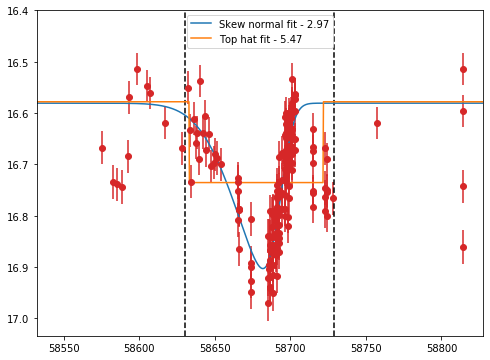

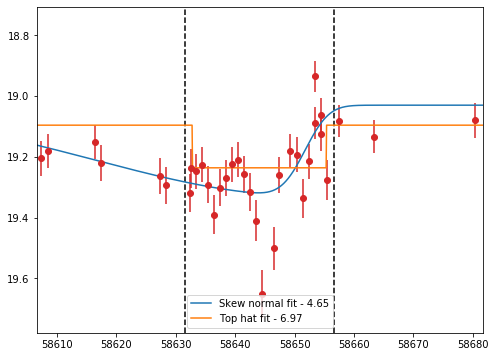

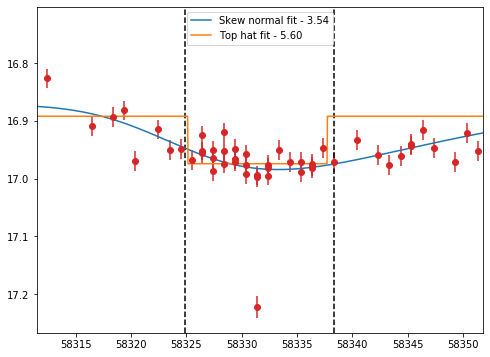

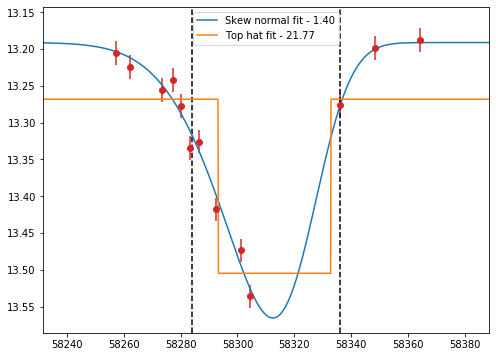

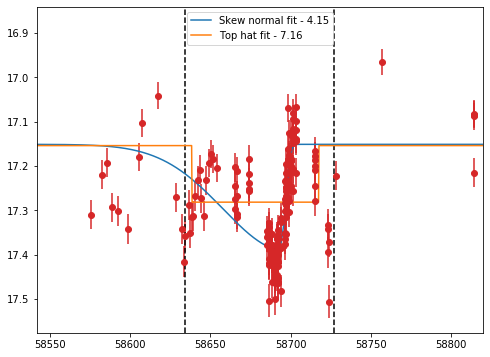

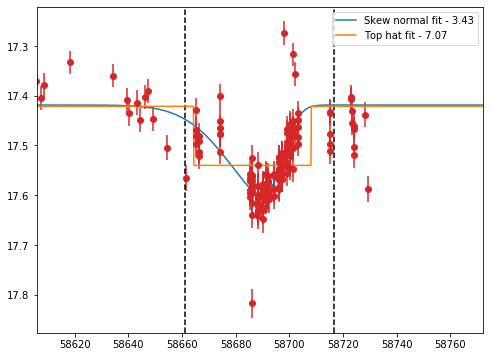

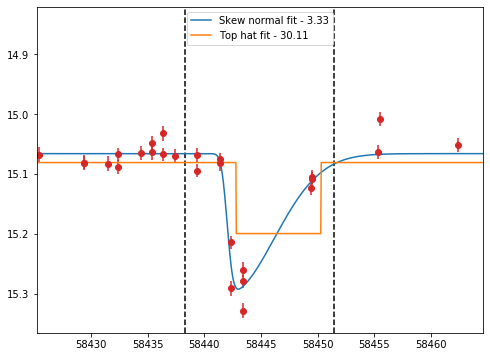

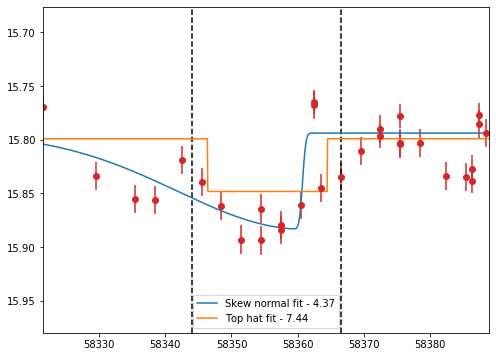

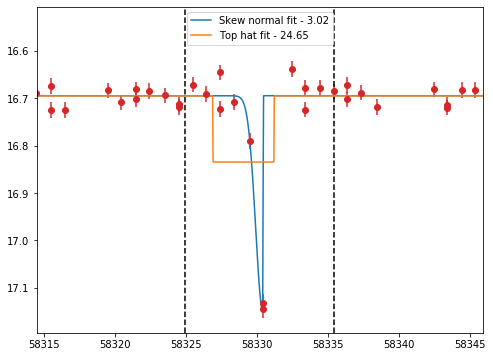

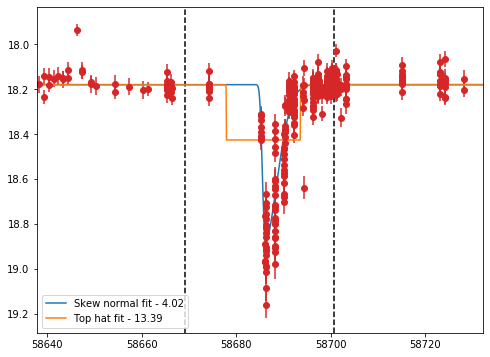

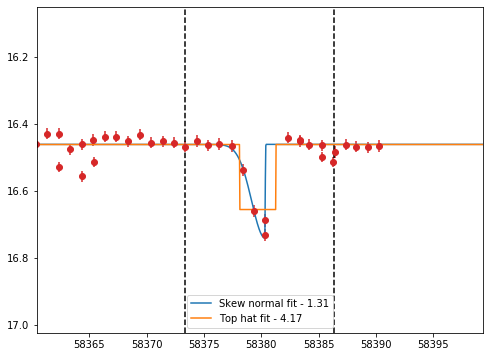

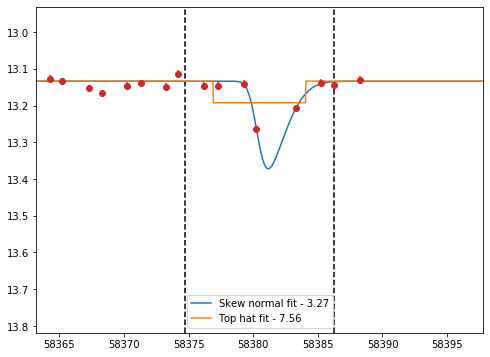

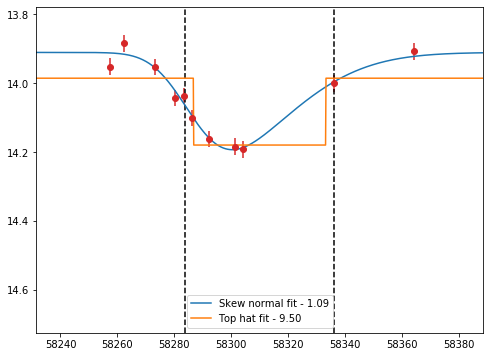

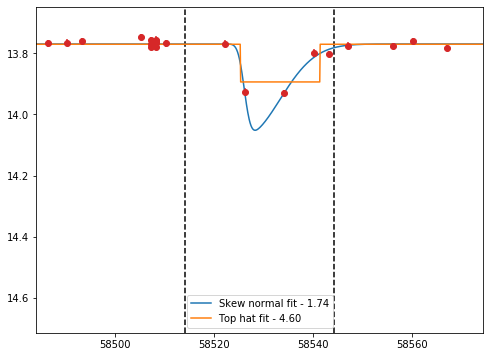

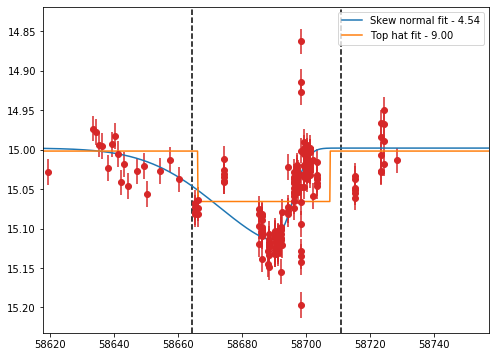

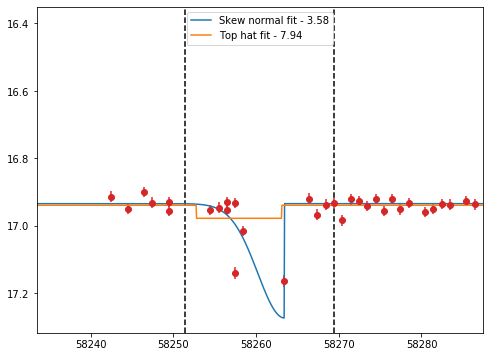

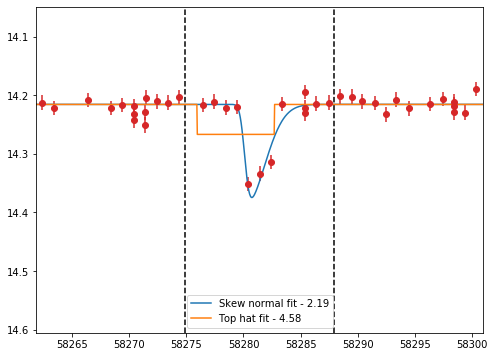

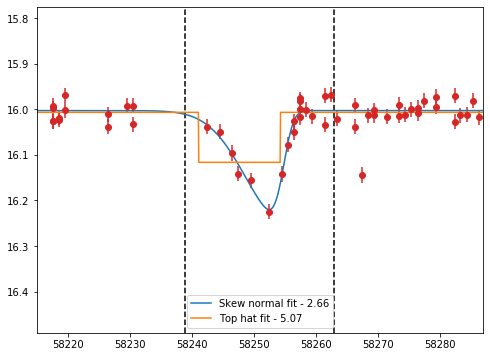

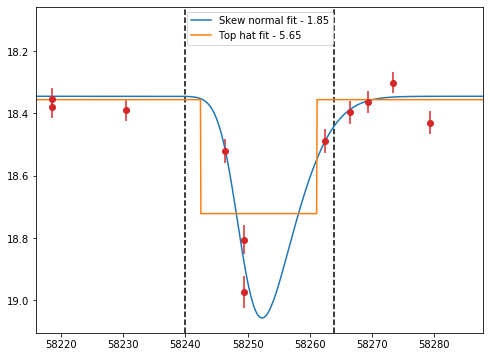

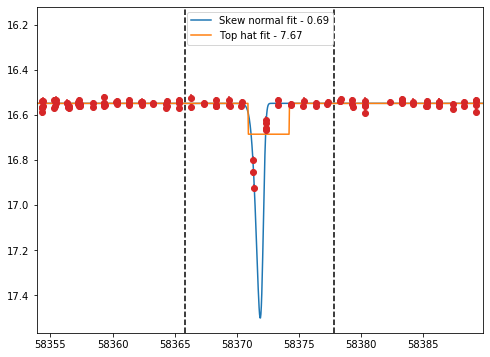

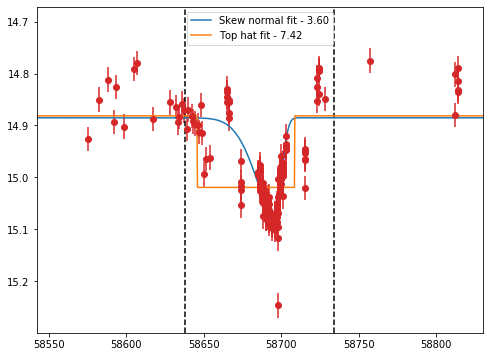

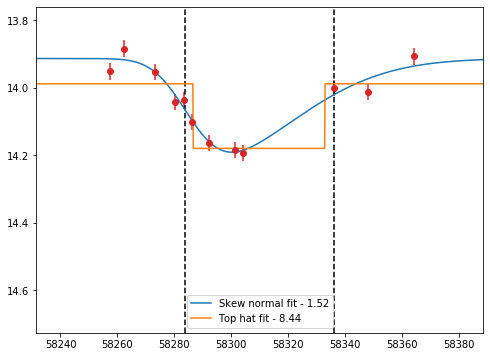

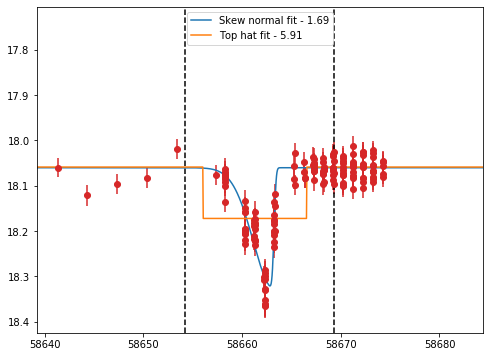

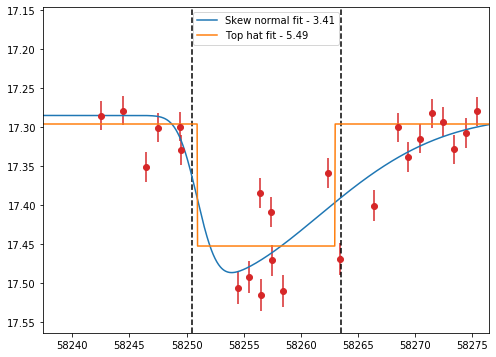

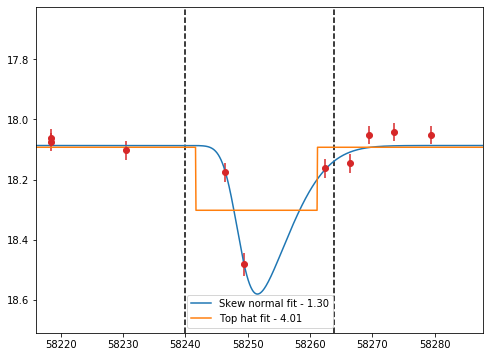

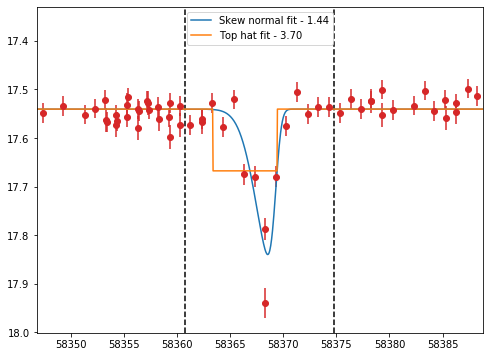

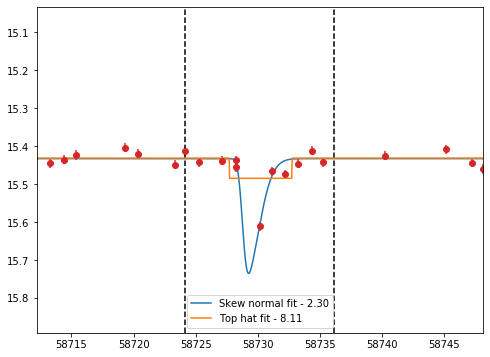

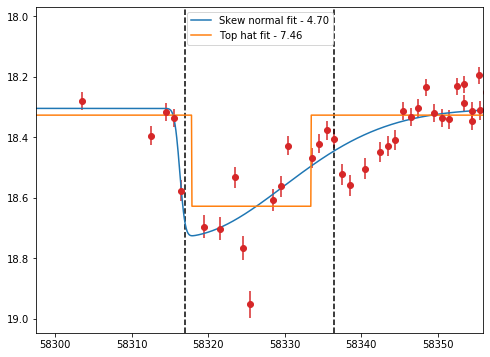

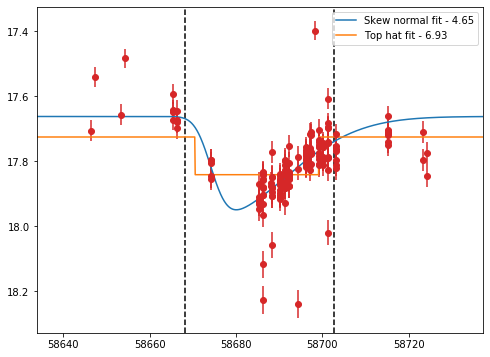

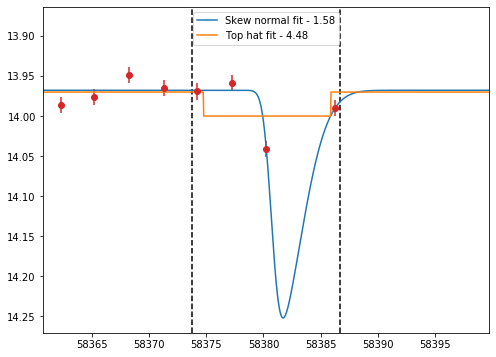

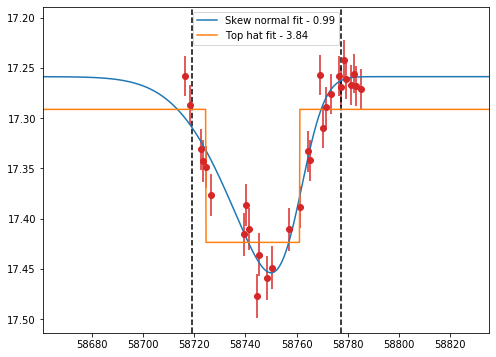

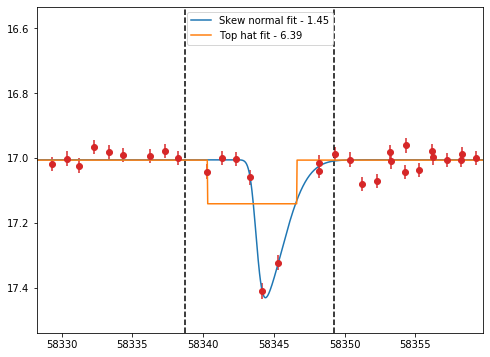

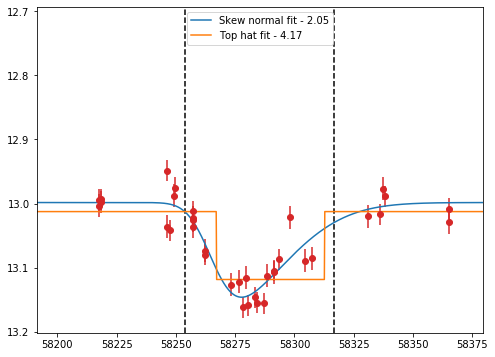

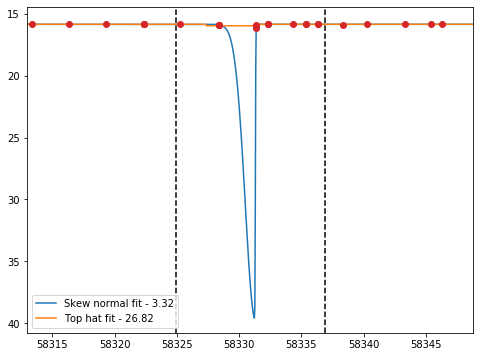

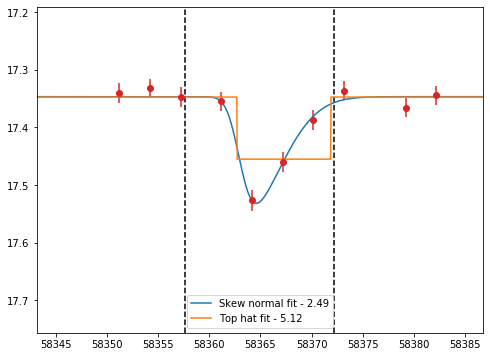

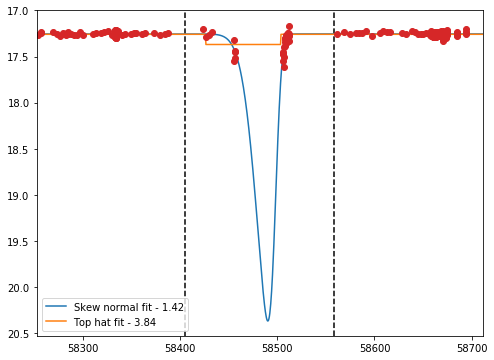

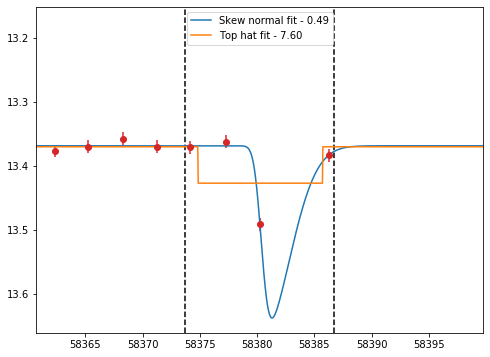

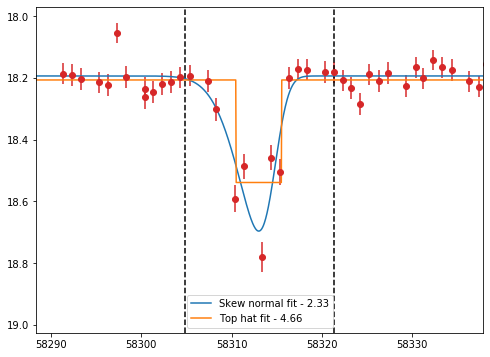

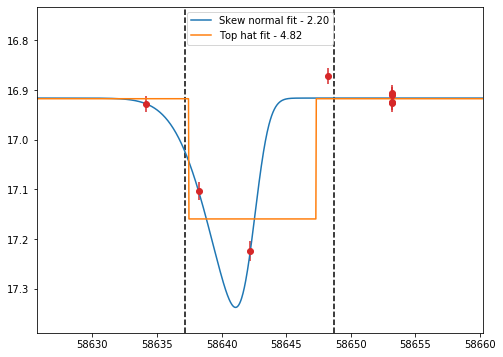

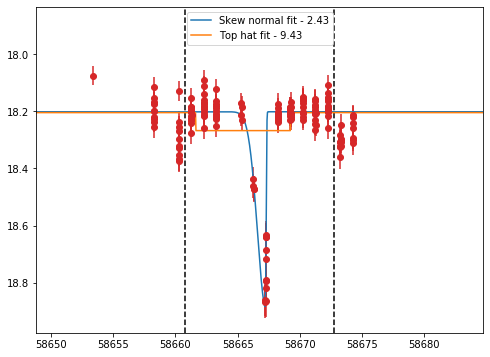

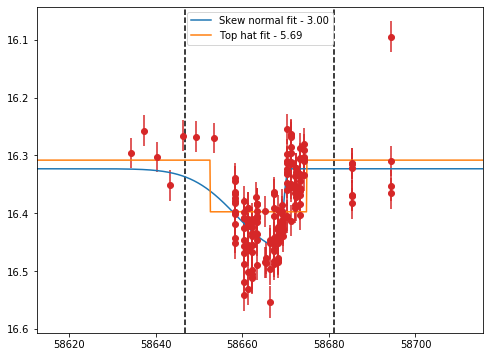

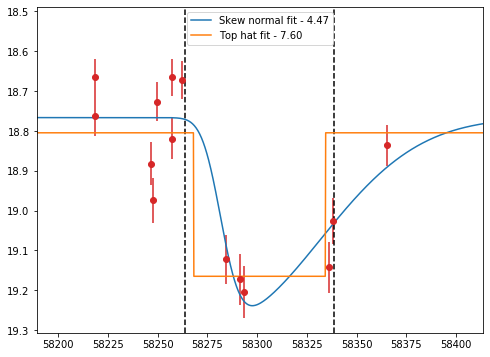

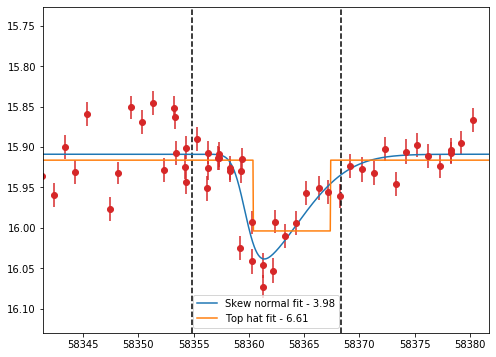

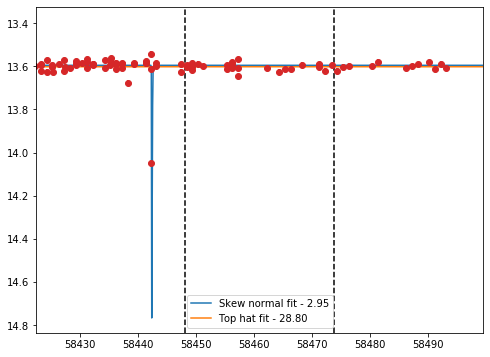

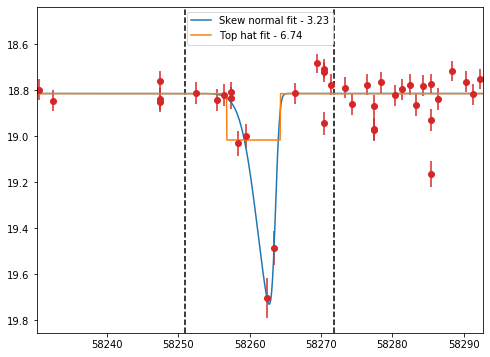

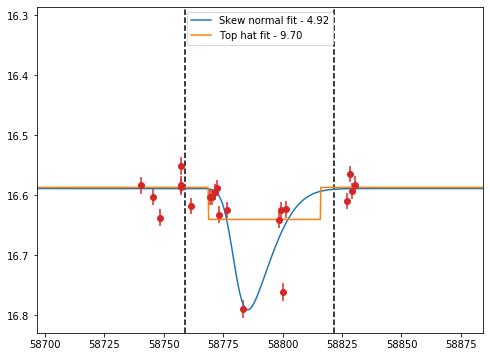

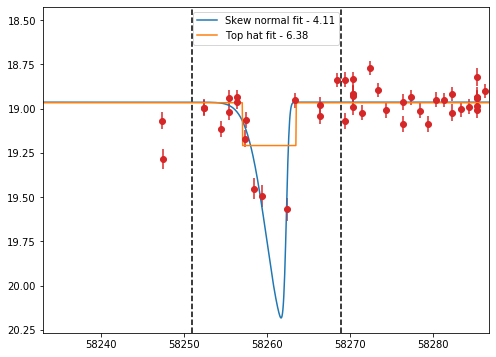

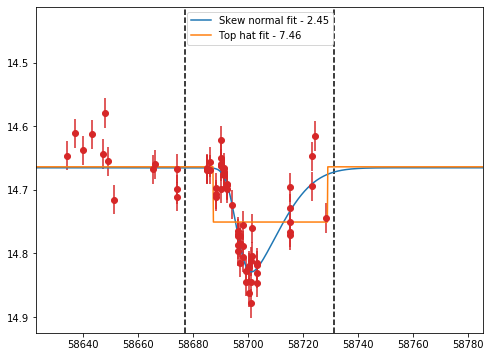

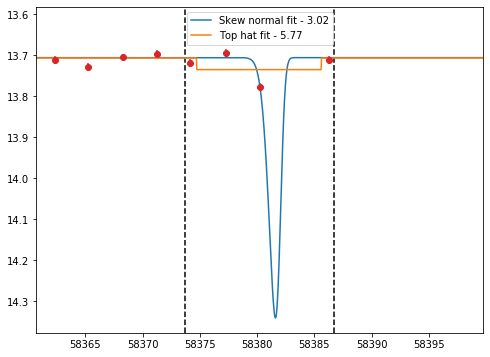

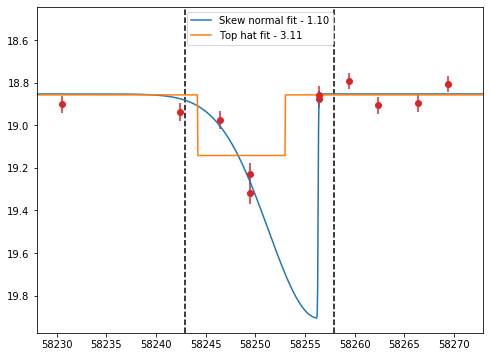

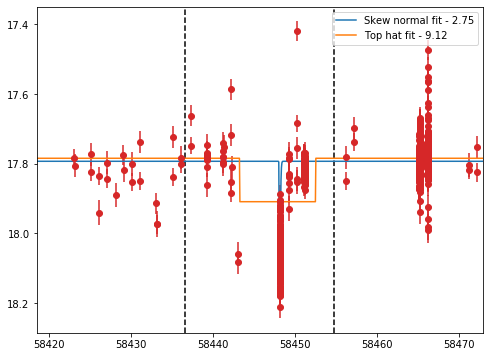

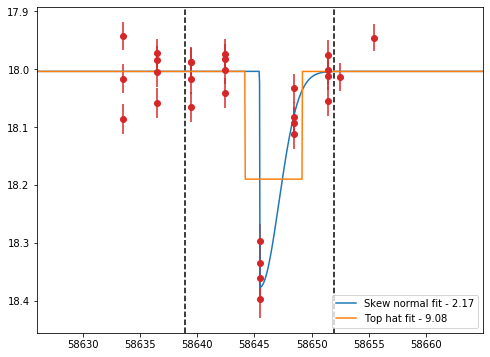

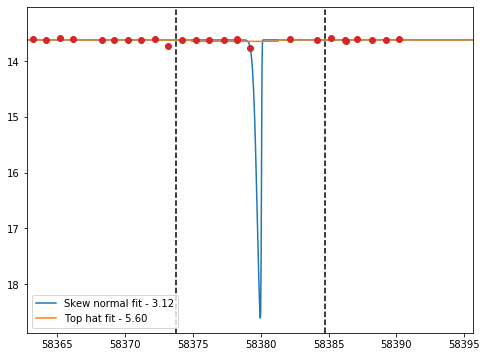

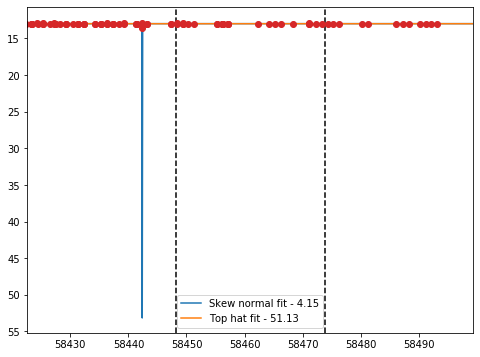

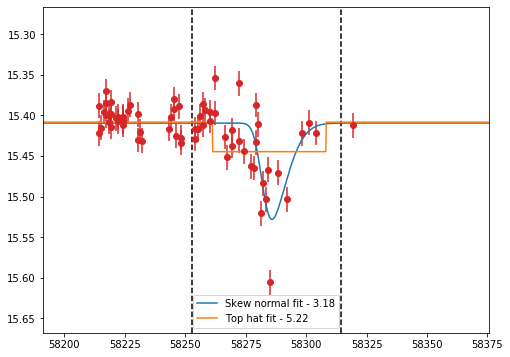

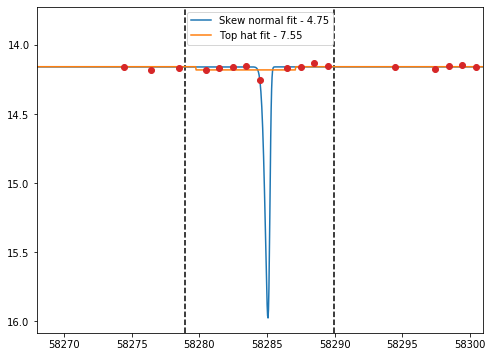

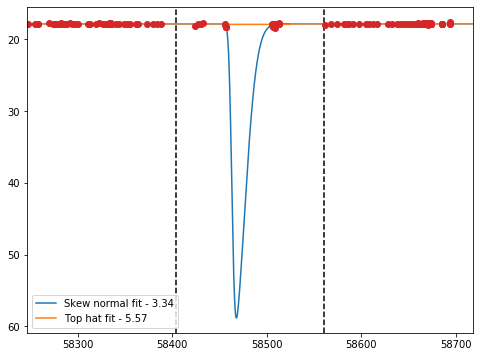

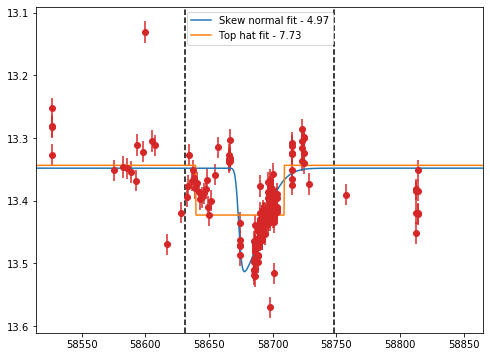

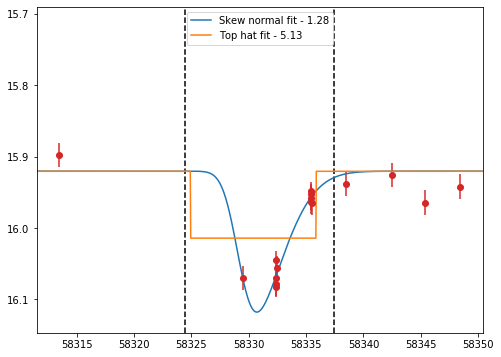

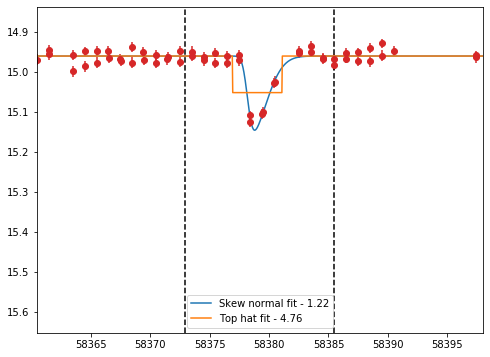

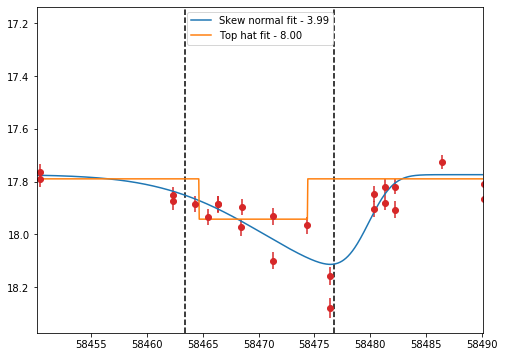

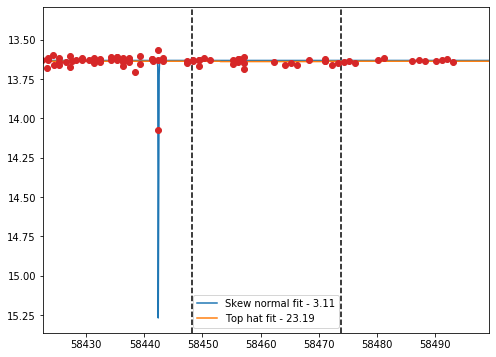

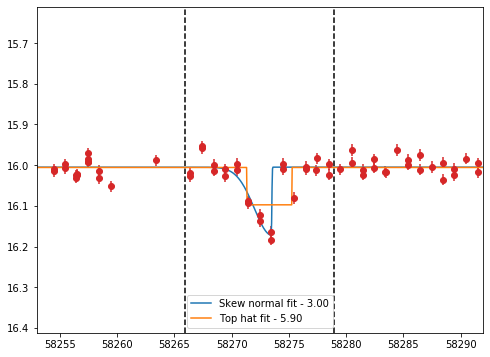

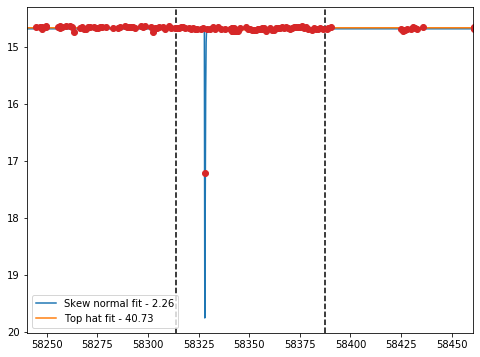

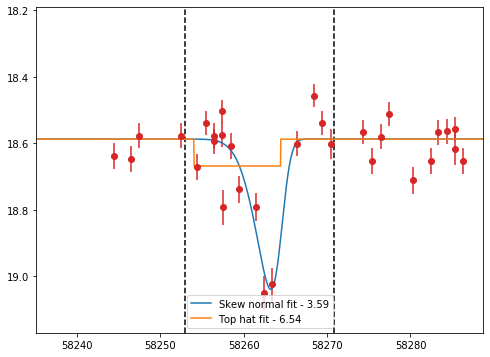

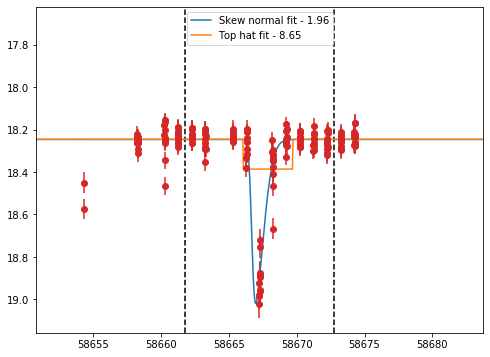

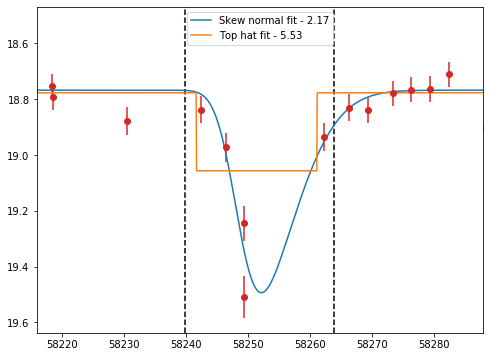

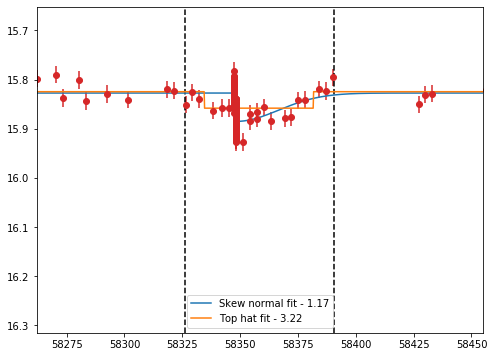

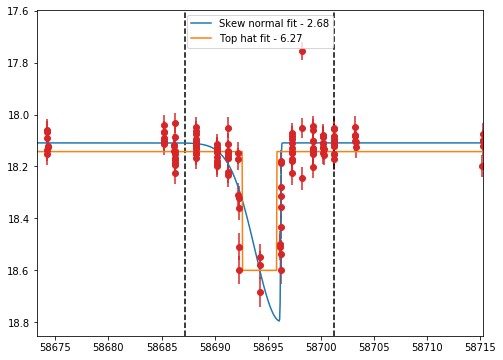

In [201]:
for i in range(100):
    plot_row(sig_df[cut].iloc[i])